## Import the neccessary package

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import wget
 
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

## Preparing the dataset

In [2]:
df = pd.read_csv("car_fuel_efficiency.csv")

In [3]:
df = df.fillna(0)

In [4]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [5]:
print(f"\nTrain size: {len(df_train)} ({len(df_train)/len(df)*100:.1f}%)")
print(f"Validation size: {len(df_val)} ({len(df_val)/len(df)*100:.1f}%)")
print(f"Test size: {len(df_test)} ({len(df_test)/len(df)*100:.1f}%)")


Train size: 5822 (60.0%)
Validation size: 1941 (20.0%)
Test size: 1941 (20.0%)


0       13.231729
1       13.688217
2       14.246341
3       16.912736
4       12.488369
          ...    
9699    15.101802
9700    17.962326
9701    17.186587
9702    15.331551
9703    14.884467
Name: fuel_efficiency_mpg, Length: 9704, dtype: float64

In [7]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [8]:
y_train = df_train["fuel_efficiency_mpg"]
y_val = df_val["fuel_efficiency_mpg"]
y_test = df_test["fuel_efficiency_mpg"]

In [9]:
del df_train['fuel_efficiency_mpg']
del df_val['fuel_efficiency_mpg']
del df_test['fuel_efficiency_mpg']

In [10]:
# Convert feature into a list of dictionaries 
train_dicts = df_train.to_dict(orient="records")
val_dicts = df_val.to_dict(orient="records")
test_dicts = df_test.to_dict(orient="records")

### Question 1

In [11]:
# Convert the list of dictionaries in a feature matrix
from sklearn.feature_extraction import DictVectorizer
dv = DictVectorizer(sparse=True)
X_train = dv.fit_transform(train_dicts)
X_val = dv.fit_transform(val_dicts)
X_test = dv.fit_transform(test_dicts)

In [12]:
# Training a decision tree regressor to predict the fuel_efficiency_mpg variable.
from sklearn.tree import DecisionTreeRegressor
dt = DecisionTreeRegressor(max_depth=1, random_state=1)
dt.fit(X_train, y_train)

# Get the feature used for splitting
feature_idx = dt.tree_.feature[0]

feature_name = dv.get_feature_names_out()[feature_idx]

print(f"\nFeature used for splitting: {feature_name}")


Feature used for splitting: vehicle_weight


### Question 2

In [13]:
# Train a random forest regressor with these parameters:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_val = rf.predict(X_val)

rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
print(f"\nRMSE on validation data: {rmse:.4f}")


RMSE on validation data: 0.4596


### Question 3
- Experiment with the n_estimators parameter

In [14]:
n_estimators_list = range(10, 201, 10)
rmse_scores = []

for n_est in n_estimators_list:
    rf = RandomForestRegressor(n_estimators=n_est, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)
    y_pred_val = rf.predict(X_val)

    rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
    rmse_scores.append((n_est, f'{rmse:.3f}'))
    # print(f"n_estimators={n_est:3d}, RMSE={rmse:.6f}")

df_scores = pd.DataFrame(rmse_scores, columns=["n_estimators", "rmse"])
df_scores

,n_estimators,rmse
0,10,0.460
1,20,0.454
2,30,0.452
3,40,0.449
4,50,0.447
5,60,0.445
6,70,0.445
7,80,0.445
8,90,0.445
9,100,0.445


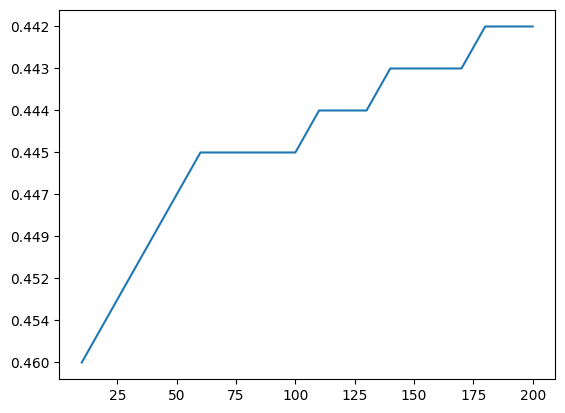

In [15]:
# x-axis - n_estimators
# y-axis - auc score
plt.plot(df_scores.n_estimators, df_scores.rmse)

### Question 4
- Selecting the best max_depth

In [60]:
max_depth_list = [10, 15, 20, 25]
n_estimators_range = range(10, 201, 10)

results = {}

for max_depth in max_depth_list:
    rmse_list = []
    for n_est in n_estimators_range:
        rf = RandomForestRegressor(
            n_estimators=n_est, max_depth=max_depth, random_state=1, n_jobs=-1
        )
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        rmse_list.append(rmse)

    mean_rmse = np.mean(rmse_list)
    results[max_depth] = mean_rmse
    print(f"max_depth={max_depth}, mean_RMSE={mean_rmse:.6f}")

best_max_depth = min(results, key=results.get)
print(f"\nBest max_depth: {best_max_depth}")

max_depth=10, mean_RMSE=0.441808
max_depth=15, mean_RMSE=0.445417
max_depth=20, mean_RMSE=0.446253
max_depth=25, mean_RMSE=0.445910

Best max_depth: 10


### Question 5
- Extracting feature importance information from tree-based models

In [38]:
rf = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

feature_names = dv.get_feature_names_out()
importances = rf.feature_importances_
importances
feature_importance_dict = dict(zip(feature_names, importances))

# Filter for the four features in question
target_features = [
    "vehicle_weight",
    "horsepower",
    "acceleration",
    "engine_displacement",
]
print("\nFeature importances for target features:")
for feat in target_features:
    if feat in feature_importance_dict:
        print(f"{feat}: {feature_importance_dict[feat]:.6f}")


# Find the most important among these
target_importances = {
    feat: feature_importance_dict[feat]
    for feat in target_features
    if feat in feature_importance_dict
}
most_important = max(target_importances, key=target_importances.get)
print(f"\nMost important feature: {most_important}")


Feature importances for target features:
vehicle_weight: 0.959150
horsepower: 0.015998
acceleration: 0.011480
engine_displacement: 0.003273

Most important feature: vehicle_weight


### Question 6
- Training an XGBoost model

In [55]:
import xgboost as xgb

features = dv.get_feature_names_out().tolist()

# DMatrix for train
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
# DMatrix for validation
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

watchlist = [(dtrain, "train"), (dval, "val")]

xgb_params_03 = {
    "eta": 0.3,
    "max_depth": 6,
    "min_child_weight": 1,
    "objective": "reg:squarederror",
    "nthread": 8,
    "seed": 1,
    "verbosity": 1,
}

model_03 = xgb.train(xgb_params_03, dtrain, num_boost_round=100, evals=watchlist, verbose_eval=False)

y_pred_03 = model_03.predict(dval)
rmse_03 = np.sqrt(mean_squared_error(y_val, y_pred_03))
print(f"RMSE with eta=0.3: {rmse_03:.6f}")

RMSE with eta=0.3: 0.450178


In [58]:
# Train with eta=0.1
print("\nTraining with eta=0.1:")
xgb_params_01 = {
    "eta": 0.1,
    "max_depth": 6,
    "min_child_weight": 1,
    "objective": "reg:squarederror",
    "nthread": 8,
    "seed": 1,
    "verbosity": 1,
}

model_01 = xgb.train(
    xgb_params_01, dtrain, num_boost_round=100, evals=watchlist, verbose_eval=False
)

y_pred_01 = model_01.predict(dval)
rmse_01 = np.sqrt(mean_squared_error(y_val, y_pred_01))
print(f"RMSE with eta=0.1: {rmse_01:.6f}")

if rmse_03 < rmse_01:
    best_eta = "0.3"
elif rmse_01 < rmse_03:
    best_eta = "0.1"
else:
    best_eta = "Both give equal value"

print(f"\nBest eta: {best_eta}")


Training with eta=0.1:
RMSE with eta=0.1: 0.426228

Best eta: 0.1
